Ziel ist zu beobachten: not MAP <=> ties

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

np.random.seed(4589)
np.seterr(all="raise")
#np.seterr(all="warn")

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [15]:
import snippets
import utils
import BinaryBP

In [16]:
num_cws = 1000
max_iters = 500
EbN0 = 2
code = snippets.n7k4_hamming

rx = snippets.simulateAWGNChannelTransmission(code, EbN0, num_cws)

bp = BinaryBP.BinaryBP(code.adjacency_matrix())

c_var = bp.c_var_Bethe()
print(c_var)
gamma = bp.gammaDefaultCBP()
print(gamma)


[-1 -1 -2 -1 -2 -2 -3]
[0.88888889 0.88888889 1.2        0.88888889 1.2        1.2
 1.45454545]


Compute MPA assignment for converged cases

In [17]:
var_beliefs = np.empty(rx.shape)
check_beliefs = np.empty((num_cws, bp.m) + bp.df_max * (2,))
iterations = np.empty(var_beliefs.shape[0])

progress_bar = IntProgress(min=0, max=num_cws)
display(progress_bar)

numerical_issues = np.zeros(num_cws, dtype=bool)
for cw_idx in range(var_beliefs.shape[0]):
    progress_bar.value = cw_idx
    try:
        (var_beliefs[cw_idx,:], check_beliefs[cw_idx,:], iterations[cw_idx]) = bp.run_llr_belief_propagation(
            max_iters=max_iters,
            rtol=1e-8,
            atol=1e-12,
            infty=1e3,
            log_factors=utils.log(code.factors_AWGN(rx[cw_idx], EbN0)),
            max_product=True,
            gamma=gamma,
            damping=0.5
        )
    except FloatingPointError as e:
        print(e)
        numerical_issues[cw_idx] = True

numerical_issues_cnt = np.sum(numerical_issues)
print(f"numerical issues for {numerical_issues_cnt / num_cws * 100}% {numerical_issues_cnt}/{num_cws}")

# discard cases with numerical issues
num_cws = num_cws - numerical_issues_cnt
rx = rx[np.logical_not(numerical_issues)]
iterations = iterations[np.logical_not(numerical_issues)]
var_beliefs = var_beliefs[np.logical_not(numerical_issues)]

converged = iterations < max_iters
converged_cnt = np.sum(converged)
print(f"{converged_cnt / num_cws * 100}% converged ({converged_cnt}/{num_cws})")
mpa_assignment = 0.5*(1-np.sign(var_beliefs)) # decode with beliefs

IntProgress(value=0)

numerical issues for 0.0% 0/100
99.0% converged (99/100)


Compute MAP assignment and compare

In [18]:
map_assignment = snippets.bruteforce_blockwiseMAP_AWGNChannel(code, rx)
mpa_unequal_map = np.sum(np.logical_xor(mpa_assignment, map_assignment), axis=1) > 0
mpa_unequal_map_cnt = np.sum(mpa_unequal_map)
print(f"MPA unequal MAP {mpa_unequal_map_cnt / num_cws * 100} % ({mpa_unequal_map_cnt}/{num_cws})")

# divide into 4 cases
converged_unequal = np.logical_and(converged, mpa_unequal_map)
converged_unequal_cnt = np.sum(converged_unequal)
converged_equal = np.logical_and(converged, np.logical_not(mpa_unequal_map))
converged_equal_cnt = np.sum(converged_equal)
if converged_cnt > 0:
    print(f"converged and unequal {converged_unequal_cnt / converged_cnt * 100} % ({converged_unequal_cnt}/{converged_cnt})")
    print(f"converged and equal {converged_equal_cnt / converged_cnt * 100} % ({converged_equal_cnt}/{converged_cnt})")
notconverged_unequal = np.logical_and(np.logical_not(converged), mpa_unequal_map)
notconverged_unequal_cnt = np.sum(notconverged_unequal)
notconverged_equal = np.logical_and(np.logical_not(converged), np.logical_not(mpa_unequal_map))
notconverged_equal_cnt = np.sum(notconverged_equal)
if converged_cnt < num_cws:
    print(f"not converged and unequal {notconverged_unequal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_unequal_cnt}/{num_cws - converged_cnt})")
    print(f"not converged and equal {notconverged_equal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_equal_cnt}/{num_cws - converged_cnt})")


MPA unequal MAP 21.0 % (21/100)
converged and unequal 20.2020202020202 % (20/99)
converged and equal 79.7979797979798 % (79/99)
not converged and unequal 100.0 % (1/1)
not converged and equal 0.0 % (0/1)


converged unequal maximum min(abs(llr)): 2.6572499262884195
converged equal minimum min(abs(llr)): 0.07868574288445736
not converged unequal maximum min(abs(llr)): 0.6579926986342164


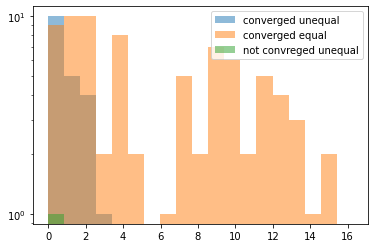

In [19]:
min_abs_llr = np.min(np.abs(var_beliefs), axis=1)

finite_llrs = min_abs_llr[min_abs_llr < float('inf')]
if len(finite_llrs) == 0:
    raise Exception("all LLRs are infinite, plotting historgramm doesn't make sense")
max_finite_llr = np.max(finite_llrs)
min_abs_llr[min_abs_llr == float('inf')] = max_finite_llr
bins = np.linspace(0, max_finite_llr + 1, 20)

if converged_unequal_cnt > 0:
    print(f"converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[converged_unequal])}")
    plt.hist(min_abs_llr[converged_unequal], bins, alpha=0.5, label="converged unequal", log=True)
if converged_equal_cnt > 0:
    print(f"converged equal minimum min(abs(llr)): {np.min(min_abs_llr[converged_equal])}")
    plt.hist(min_abs_llr[converged_equal], bins, alpha=0.5, label="converged equal", log=True)
if notconverged_unequal_cnt > 0:
    print(f"not converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[notconverged_unequal])}")
    plt.hist(min_abs_llr[notconverged_unequal], bins, alpha=0.5, label="not convreged unequal", log=True)
if notconverged_equal_cnt > 0:
    print(f"not converged equal minimum min(abs(llr)): {np.min(min_abs_llr[notconverged_equal])}")
    plt.hist(min_abs_llr[notconverged_equal], bins, alpha=0.5, label="not converged equal", log=True)
plt.legend()
plt.show()

In [20]:
arg_weired = np.nonzero(converged_unequal)[0][np.argmax(min_abs_llr[converged_unequal])]
print(arg_weired)

50
